<a href="https://colab.research.google.com/github/gmihaila/ml_things/blob/master/notebooks/pytorch/vae_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VAE for anomali detection


Resources:

* [Hands-on Anomaly Detection with Variational Autoencoders](https://towardsdatascience.com/hands-on-anomaly-detection-with-variational-autoencoders-d4044672acd5) [Code](https://github.com/a-agmon/anomaly_det/blob/master/AnomalyDetectorsVAE-KDD-original.ipynb)

* [Variational Autoencoder Demystified With PyTorch Implementation.](https://towardsdatascience.com/variational-autoencoder-demystified-with-pytorch-implementation-3a06bee395ed) [Code](https://colab.research.google.com/drive/1_yGmk8ahWhDs23U4mpplBFa-39fsEJoT?usp=sharing)

* Original Paper: [Auto-Encoding Variational Bayes](https://arxiv.org/pdf/1312.6114.pdf)


* [Intuitively Understanding Variational Autoencoders](https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf)


* [Variational Auto Encoder with missing data](https://medium.com/@ebrahim.soroush/variational-auto-encoder-with-missing-data-b975abd0a9c)



Future Direction:

* [Synthesis of Tabular Data in Finance using Generative Algorithms](https://towardsdatascience.com/synthesis-of-tabular-financial-data-using-generative-algorithms-e90415f889ba)

* [Synthesizing Tabular Data using Conditional GAN](https://dai.lids.mit.edu/wp-content/uploads/2020/02/Lei_SMThesis_neo.pdf)

* [How do you generate synthetic data?](https://www.statice.ai/post/how-generate-synthetic-data)

* !!! [Generate Synthetic Dataset with the Synthetic Data Vault (SDV)](https://medium.com/geekculture/generate-synthetic-dataset-with-the-synthetic-data-vault-sdv-26b564b8fe15)


Projects:

* [Synthetic Data Vault (SDV)](https://github.com/sdv-dev/SDV)
* [PyTorch-VAE](https://github.com/AntixK/PyTorch-VAE)



To Read:

* [Open repository with GAN architectures for tabular data implemented using Tensorflow 2.0.](https://reposhub.com/python/deep-learning/ydataai-ydata-synthetic.html)

* [Generating artificial tabular data with an encoder/decoder](https://medium.com/mlearning-ai/generating-artificial-tabular-data-with-an-encoder-decoder-5e4de9b4d02e)

* [Modeling Tabular Data using Conditional GAN](https://proceedings.neurips.cc/paper/2019/file/254ed7d2de3b23ab10936522dd547b78-Paper.pdf)

* [Synthesising artificial patient-level data for Open Science - an evaluation of five methods](https://www.medrxiv.org/content/10.1101/2020.10.09.20210138v1.full?__cf_chl_jschl_tk__=cOMCBMWsayamfvII_m7SYcbgJWDM7fQumzv_kcgYk2c-1638762681-0-gaNycGzNCL0)

* [Generating Tabular Synthetic Data Using GANs](https://www.maskaravivek.com/post/gan-synthetic-data-generation/)

* [Synthetic Data Generation](https://paperswithcode.com/task/synthetic-data-generation/latest)

* [An overview of synthetic data types and generation methods](https://www.kdnuggets.com/2021/02/overview-synthetic-data-types-generation-methods.html)

* [Working with Deep Generative Models and Tabular Data Imputation](https://openreview.net/pdf?id=R4w3PTkCD4)



# Imports

In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

scaler = MinMaxScaler()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

urls = [
        "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz",
        "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names"
        ]

# Helper Funcitons

In [2]:
def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)


# Data

## Read Data

In [3]:
# Get columns names of data.
columns_names_df = pd.read_csv(urls[1], skiprows=1, sep=':', names=['f_names', 'f_types'])
columns_names_df.loc[columns_names_df.shape[0]] = ['status', ' symbolic.']

columns_names = columns_names_df['f_names'].to_list()


symbolic_columns_names_df = columns_names_df[columns_names_df['f_types'].str.contains('symbolic.')]
continuous_columns_names_df = columns_names_df[columns_names_df['f_types'].str.contains('continuous.')]

data_df = pd.read_csv(urls[0], header=None, names=columns_names)

samples = pd.get_dummies(data_df.iloc[:, :-1], columns=symbolic_columns_names_df['f_names'][:-1])

labels = np.where(data_df['status'] == 'normal.', 1, 0)


samples

duration  src_bytes  ...  is_guest_login_0  is_guest_login_1
0              0        181  ...                 1                 0
1              0        239  ...                 1                 0
2              0        235  ...                 1                 0
3              0        219  ...                 1                 0
4              0        217  ...                 1                 0
...          ...        ...  ...               ...               ...
494016         0        310  ...                 1                 0
494017         0        282  ...                 1                 0
494018         0        203  ...                 1                 0
494019         0        291  ...                 1                 0
494020         0        219  ...                 1                 0

[494021 rows x 121 columns]

## Process Data

In [4]:
# Scale Data
data_scaled = scaler.fit_transform(samples)
print("data_scaled", data_scaled.shape)

norm_samples = data_scaled[labels == 1]  # normal data
attack_samples = data_scaled[labels == 0]  # attack data

norm_labels = labels[labels == 1]
attack_labels = labels[labels == 0]

print("attack_samples", attack_samples.shape)

# generate train set
# training set will consist of the normal ds

len_norm = len(norm_samples)
len_norm_train = int(0.8 * len_norm)
X_train = norm_samples[:len_norm_train]

# generate test set consist of 50% attack and 50% normal

X_test_norm = norm_samples[len_norm_train:]
len_attack_test = len(X_test_norm) # we will use the same number
X_test_attack = attack_samples[:len_attack_test]

X_test = np.concatenate([X_test_norm, X_test_attack])
y_test = np.ones(len(X_test))
y_test[:len(X_test_norm)] = 0

print("Train", X_train.shape)
print("Test", X_test.shape)

data_scaled (494021, 121)
attack_samples (396743, 121)
Train (77822, 121)
Test (38912, 121)


## Data Loader

In [5]:
class KddDataset(Dataset):
  """PyTorch Dataset.
  """

  def __init__(self, normalized_data):
    self.all_data = normalized_data
    return

  def __len__(self):
    return len(self.all_data)

  def __getitem__(self, item):
    return torch.tensor(self.all_data[item], dtype=torch.float32)

# create pytorch dataset
train_dataset = KddDataset(normalized_data=X_train)
# move pytorch dataset into dataloader
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)

# Modeling

## Parameters

In [6]:
original_dim = X_train.shape[1]
input_shape = original_dim
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)

print(f"original_dim: {original_dim}\ninput_shape: {input_shape}\nintermediate_dim: {intermediate_dim}\nlatent_dim: {latent_dim}")

original_dim: 121
input_shape: 121
intermediate_dim: 60
latent_dim: 40


## Model

In [7]:
class Encoder(torch.nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = torch.nn.Linear(in_features=input_shape, 
                                   out_features=intermediate_dim)
        self.fc_mu = torch.nn.Linear(in_features=intermediate_dim, 
                               out_features=latent_dim)
        self.fc_logvar = torch.nn.Linear(in_features=intermediate_dim, 
                                   out_features=latent_dim)
    
    def forward(self, x):
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class Decoder(torch.nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = torch.nn.Linear(in_features=latent_dim, 
                                   out_features=intermediate_dim)
        self.fc2 = torch.nn.Linear(in_features=intermediate_dim, 
                               out_features=original_dim)
    
    def forward(self, x):
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        x = self.fc2(x)
        output = torch.sigmoid(x)
        return output

class VariationalAutoencoder(torch.nn.Module):
  def __init__(self,):
    super(VariationalAutoencoder, self).__init__()

    self.encoder = Encoder()
    self.decoder = Decoder()


  def forward(self, x):
    latent_mu, latent_logvar = self.encoder(x)
    latent = self.latent_sample(latent_mu, latent_logvar)
    x_recon = self.decoder(latent)
    return x_recon, latent_mu, latent_logvar

  def latent_sample(self, mu, logvar):
    # SAMPLE Z from Q(Z|x)
    # std = torch.exp(log_var / 2)
    # q = torch.distributions.Normal(mu, std)
    # z = q.rsample()
    if self.training:
      # the reparameterization trick
      std = logvar.mul(0.5).exp_()
      eps = torch.empty_like(std).normal_()
      return eps.mul(std).add_(mu)
    else:
      return mu

# the KL loss function:
def variational_autoencoder_loss(x, x_decoded_mean, mu, logvar):
    # compute the average MSE error, then scale it up, ie. simply sum on all axes
    reconstruction_loss = torch.sum(torch.square(x - x_decoded_mean))
    # compute the KL loss
    kl_loss = - 0.5 * torch.sum(1 + logvar - torch.square(mu) - torch.square(torch.exp(logvar)), axis=-1)
    # return the average loss over all 
    total_loss = torch.mean(reconstruction_loss + kl_loss)    
    #total_loss = reconstruction_loss + kl_loss
    return total_loss




vae = VariationalAutoencoder()

vae.to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: {:,}'.format(num_params))

Number of parameters: 22,041


## Train

In [8]:
learning_rate = 1e-3
num_epochs = 32

optimizer = torch.optim.Adam(params=vae.parameters(), 
                             lr=learning_rate, 
                             weight_decay=1e-5)

# set to training mode
vae.train()

train_losses = []

for epoch in tqdm(range(num_epochs), desc='Epochs'):

  batch_loss = 0

  for batch in train_dataloader:
    batch_on_device = batch.to(device)

    # vae reconstruction
    reconstructed_batch, latent_mu, latent_logvar = vae(batch_on_device)

    # reconstruction error
    loss = variational_autoencoder_loss(batch_on_device, reconstructed_batch, 
                                        latent_mu, latent_logvar)

    # backpropagation
    optimizer.zero_grad()
    loss.backward()

    # Clip gradients
    torch.nn.utils.clip_grad_value_(vae.parameters(), clip_value=0.5)
    
    # one step of the optmizer (using the gradients from backpropagation)
    optimizer.step()
    
    batch_loss += loss.item()

  batch_loss /= len(train_dataloader)
  print(f"\tEpoch {epoch}/{num_epochs} Loss: {batch_loss}")
  train_losses.append(batch_loss)

Epochs:   0%|          | 0/32 [00:00<?, ?it/s]

	Epoch 0/32 Loss: 912.3665855558295
	Epoch 1/32 Loss: 73.51317616512901
	Epoch 2/32 Loss: 51.67098285022535
	Epoch 3/32 Loss: 44.8618470932308
	Epoch 4/32 Loss: 40.213116658361336
	Epoch 5/32 Loss: 36.788812016185965
	Epoch 6/32 Loss: 33.54846089764645
	Epoch 7/32 Loss: 31.266461027295964
	Epoch 8/32 Loss: 29.039670605408517
	Epoch 9/32 Loss: 26.28564584882636
	Epoch 10/32 Loss: 24.565667011235888
	Epoch 11/32 Loss: 22.962767428473423
	Epoch 12/32 Loss: 20.87679779215863
	Epoch 13/32 Loss: 18.572035312652588
	Epoch 14/32 Loss: 17.795817409691058
	Epoch 15/32 Loss: 17.216387231098977
	Epoch 16/32 Loss: 16.70039581938794
	Epoch 17/32 Loss: 15.91408900210732
	Epoch 18/32 Loss: 15.051911212896046
	Epoch 19/32 Loss: 14.611310547903964
	Epoch 20/32 Loss: 14.190809209095804
	Epoch 21/32 Loss: 13.799502178242331
	Epoch 22/32 Loss: 13.4509586315406
	Epoch 23/32 Loss: 13.155446996814327
	Epoch 24/32 Loss: 12.912123178180895
	Epoch 25/32 Loss: 12.710282300647936
	Epoch 26/32 Loss: 12.523861351766

## Plot

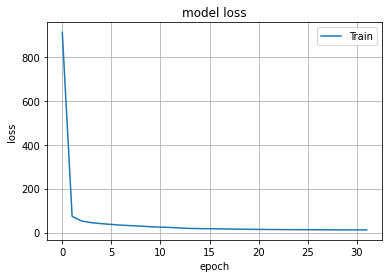

In [9]:
plt.plot(train_losses, label='Train')
#plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right');
plt.grid()
plt.show()

# Evaluation

In [10]:
# Test prediciton
X_train_pt = torch.tensor(X_train, dtype=torch.float32)

with torch.no_grad():
  X_train_pred_pt, _, _ = vae(X_train_pt)

X_train_pred = X_train_pred_pt.detach().cpu().numpy()

mae_vector = get_error_term(X_train_pred, X_train, _rmse=False)

print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')

error_thresh = np.quantile(mae_vector, 0.99)

Avg error 0.001786449770490734
median error 0.001327826968646513
99Q: 0.009201536591006705


# Check Anomaly Detection

In [11]:
X_test_pt = torch.tensor(X_test, dtype=torch.float32)

with torch.no_grad():
  X_pred, _, _ = vae(X_test_pt)
X_pred = X_pred.detach().cpu().numpy()

mae_vector = get_error_term(X_pred, X_test, _rmse=False)
anomalies = (mae_vector > error_thresh)

np.count_nonzero(anomalies) / len(anomalies)

print(classification_report(y_test, anomalies))

              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94     19456
         1.0       0.98      0.90      0.94     19456

    accuracy                           0.94     38912
   macro avg       0.95      0.94      0.94     38912
weighted avg       0.95      0.94      0.94     38912



# New Data Generated

In [31]:
# Test prediciton
X_train_pt = torch.tensor(X_train, dtype=torch.float32)

with torch.no_grad():
  X_train_pred_pt, mu, log_var = vae(X_train_pt)

# SAMPLE Z from Q(Z|x)
std = torch.exp(log_var / 2)


# Z COMES FROM NORMAL(0, 1)
num_preds = 1
p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
z = p.rsample((num_preds,))

# SAMPLE IMAGES
with torch.no_grad():
    pred = vae.decoder(z.to(device)).cpu()

original_reconstructed = scaler.inverse_transform(pred[0])
original_reconstructed_df = pd.DataFrame(data=original_reconstructed, columns=samples.columns)
original_reconstructed_df

duration      src_bytes  ...  is_guest_login_0  is_guest_login_1
0         0.011846   12894.588383  ...          1.000000      1.669098e-08
1         1.536402   36507.489192  ...          0.999999      1.301142e-06
2         0.015478    1873.309007  ...          1.000000      2.893285e-09
3         0.714861   43595.281017  ...          0.999995      3.151481e-06
4        70.478422  427680.378257  ...          0.998447      1.373435e-03
...            ...            ...  ...               ...               ...
77817     6.053116  454363.839331  ...          1.000000      4.978445e-07
77818     0.000630    7144.002901  ...          1.000000      1.805475e-08
77819    12.193587   86251.137842  ...          0.999482      5.720104e-04
77820  1139.566284  264367.841526  ...          0.999999      1.142047e-06
77821     0.000203      13.442088  ...          1.000000      8.643796e-10

[77822 rows x 121 columns]

In [33]:
original_reconstructed_df.describe()

duration     src_bytes  ...  is_guest_login_0  is_guest_login_1
count  7.782200e+04  7.782200e+04  ...      77822.000000      7.782200e+04
mean   8.540272e+01  1.770741e+05  ...          0.997667      2.264991e-03
std    3.669822e+02  3.868523e+05  ...          0.025257      2.493192e-02
min    1.751721e-12  8.069306e-05  ...          0.024650      2.646138e-18
25%    2.299260e-02  4.118238e+03  ...          0.999954      9.074751e-08
50%    9.194685e-01  3.353729e+04  ...          0.999998      2.434594e-06
75%    1.896454e+01  1.667525e+05  ...          1.000000      4.807372e-05
max    1.490611e+04  6.806251e+06  ...          1.000000      9.781983e-01

[8 rows x 121 columns]

In [32]:
samples.describe()

duration     src_bytes  ...  is_guest_login_0  is_guest_login_1
count  494021.000000  4.940210e+05  ...     494021.000000     494021.000000
mean       47.979302  3.025610e+03  ...          0.998613          0.001387
std       707.746472  9.882181e+05  ...          0.037211          0.037211
min         0.000000  0.000000e+00  ...          0.000000          0.000000
25%         0.000000  4.500000e+01  ...          1.000000          0.000000
50%         0.000000  5.200000e+02  ...          1.000000          0.000000
75%         0.000000  1.032000e+03  ...          1.000000          0.000000
max     58329.000000  6.933756e+08  ...          1.000000          1.000000

[8 rows x 121 columns]

In [45]:
corr = original_reconstructed_df.corr()

corr.style.background_gradient(cmap='coolwarm').set_precision(2)

In [44]:
corr = samples.corr()

corr.style.background_gradient(cmap='coolwarm').set_precision(2)

/usr/local/lib/python3.7/dist-packages/pandas/io/formats/style.py:1126: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
/usr/local/lib/python3.7/dist-packages/pandas/io/formats/style.py:1127: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax
